# RCNN - model for Classification

### Resources
<a href="https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/">IOU</a>

<a href="https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55">Overall Guide</a>

### IOU
* this is just an evaluation metric
* this requires two things:
    * ground truth boxes - the hand labeld bounding boxes from the testing set that specify where in the image our object is.
    * the predicted vounding boxes from our model
    
    IOU= (area of overlap) / (area of union)

In [1]:
# all the required lib
import os, cv2, keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2022-04-24 20:13:58.681022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dhruv/.conda/envs/ml/lib/python3.10/site-packages/cv2/../../lib64:
2022-04-24 20:13:58.681058: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
ss= cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [18]:
cd airplanes/Images/

/home/dhruv/drone-defense-wall/data/airplanes/Images


In [36]:
print('aa')

aa


In [70]:
cd drone-defense-wall/data/airplanes/

/home/dhruv/drone-defense-wall/data/airplanes


In [71]:
pwd

'/home/dhruv/drone-defense-wall/data/airplanes'

In [72]:
ls

annot/  Images/


In [73]:
path = "Images"
annot = "Airplanes_Annotations"

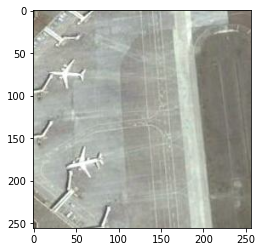

In [67]:
plt.imshow(image)

In [ ]:
train_images=[]
train_labels=[]
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_435.jpg
1 airplane_104.jpg
2 airplane_040.jpg
3 airplane_021.jpg
4 airplane_461.jpg
5 airplane_271.jpg
6 airplane_404.jpg
7 airplane_599.jpg
8 airplane_262.jpg
9 airplane_572.jpg
10 airplane_318.jpg
11 airplane_397.jpg
12 airplane_082.jpg
13 airplane_589.jpg
14 airplane_219.jpg
15 airplane_479.jpg
16 airplane_167.jpg
17 airplane_265.jpg
18 airplane_688.jpg
19 airplane_596.jpg
inside
20 airplane_370.jpg
21 airplane_407.jpg
23 airplane_039.jpg
24 airplane_192.jpg
25 airplane_033.jpg
26 airplane_584.jpg
27 airplane_224.jpg
28 airplane_537.jpg
29 airplane_398.jpg
30 airplane_303.jpg
31 airplane_665.jpg
32 airplane_339.jpg
33 airplane_647.jpg
34 airplane_183.jpg
35 airplane_197.jpg
36 airplane_217.jpg
37 airplane_519.jpg
38 airplane_680.jpg
39 airplane_139.jpg
40 airplane_517.jpg
41 airplane_231.jpg
42 airplane_048.jpg
43 airplane_173.jpg
44 airplane_558.jpg
45 airplane_071.jpg
46 airplane_685.jpg
47 airplane_631.jpg
48 airplane_315.jpg
inside
49 airplane_096.jpg
inside
50 airpla

399 airplane_444.jpg
400 airplane_373.jpg
inside
402 airplane_297.jpg
inside
405 airplane_580.jpg
406 airplane_025.jpg
407 airplane_044.jpg
408 airplane_273.jpg
410 airplane_510.jpg
411 airplane_180.jpg
412 airplane_243.jpg
413 airplane_349.jpg
414 airplane_536.jpg
415 airplane_106.jpg
416 airplane_220.jpg
417 airplane_464.jpg
418 airplane_225.jpg
inside
419 airplane_108.jpg
inside
420 airplane_182.jpg
421 airplane_138.jpg
422 airplane_129.jpg
423 airplane_473.jpg
424 airplane_156.jpg
426 airplane_279.jpg
427 airplane_561.jpg
inside
428 airplane_543.jpg
429 airplane_598.jpg
430 airplane_161.jpg
431 airplane_293.jpg
432 airplane_396.jpg
433 airplane_629.jpg
434 airplane_627.jpg
435 airplane_525.jpg
436 airplane_542.jpg
437 airplane_677.jpg
438 airplane_559.jpg
439 airplane_597.jpg
440 airplane_655.jpg
441 airplane_673.jpg
442 airplane_148.jpg
443 airplane_280.jpg
444 airplane_684.jpg
445 airplane_015.jpg
446 airplane_109.jpg
447 airplane_165.jpg
448 airplane_056.jpg
449 airplane_230.jpg

In [69]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

2022-04-21 17:28:21.944722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 17:28:21.945806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dhruv/.conda/envs/ml/lib/python3.10/site-packages/cv2/../../lib64:
2022-04-21 17:28:21.946142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dhruv/.conda/envs/ml/lib/python3.10/site-packages/cv2/../../lib64:
2022-04-21 17:28:21.946395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'

553476096/553467096 [==============================] - 163s 0us/step


2022-04-21 17:31:07.666527: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
